In [2]:
%cd /content/drive/MyDrive/Github/floread
!git checkout feature_sentiment-analysis

/content/drive/MyDrive/Github/floread
Already on 'feature_sentiment-analysis'
Your branch is up to date with 'origin/feature_sentiment-analysis'.


In [3]:
!pip install transformers
import pandas as pd

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.9 MB/s eta 0:00:00


In [4]:
%cd /content/drive/MyDrive/Github/floread/sentiment-analysis

train_set = pd.read_csv('data/병합데이터셋-v3.csv', index_col=0)
train_set.sample(n=5)

/content/drive/MyDrive/Github/floread/sentiment-analysis


,sentence,emotion
109549,기다리시면 알게 됩니다.,중립
56722,그럼 집에서 커피를 한잔 타서 책상에 앉아 백색소음유투브를 틀어놓고 공부하면 되는거...,중립
93328,그래그래. 이제 우리도 여자애들하고 놀러 가자.,중립
46124,"왜, 나만 있어서 불만있냐?",중립
93321,옆집 아줌마는 이번에 다쳐서 손실보험 탔다고 기뻐하던데 나는 그럴 일이 없어서 다행이야.,행복


In [5]:
# 감정을 정수 라벨로 변경
emotions = {'행복': 0, '불안': 1, '놀람': 2, '슬픔': 3, '분노': 4, '중립': 5}
train_set['emotion'] = train_set.emotion.map(emotions)

train_set.sample(n=5)

,sentence,emotion
128843,"너, 중학생 때 이런 생각 했지? 고등학생 되면 여친 생기겠지, 뭐 그런 거.",5
132487,어떻게야 할지 막막해요 ㅠㅠ,3
103872,"그래서, 절 의심하는 거예요?",5
77737,왜 따라내요? 이게 제일 진하게 우러난 물인데.,5
34321,딸의 결혼에 예단도 제대로 못 해준 것이 후회되어 슬퍼.,3


In [6]:
# torch.utils.data.Dataset 상속
class mscDataset(Dataset):  #multi-label sentiment classification
  def __init__(self, csv_file):
    # 결측치 제거
    self.dataset = csv_file
    # 중복값 제거
    self.dataset.drop_duplicates(subset=['sentence'], inplace=True)
    self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

    print(self.dataset.describe())

#   def __init__(self, csv_file):
#     self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")
#     print(self.dataset.describe())

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [7]:
train_data, test_data = train_test_split(train_set, test_size=0.2, random_state=0)
train_dataset = mscDataset(train_data)
test_dataset = mscDataset(test_data)

             emotion
count  108617.000000
mean        3.113343
std         1.738215
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         5.000000
            emotion
count  27159.000000
mean       3.115800
std        1.739844
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        5.000000


In [8]:
#모델 불러오기
device = torch.device("cuda:0") #(colab)그냥 "cuda"로 하면 애러
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", num_labels=6).to(device)

# 하이퍼 파라미터
epochs = 6
batch_size = 16
optimizer = AdamW(model.parameters(), lr=5e-6)

#데이터 로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [9]:
# 학습
losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

  model.eval()
  test_correct = 0
  test_total = 0
  for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    _, predicted = torch.max(y_pred, 1)
    test_correct += (predicted == y_batch).sum()
    test_total += len(y_batch)
  print("epoch",i," Accuracy:", test_correct.float() / test_total)

  0%|          | 0/6789 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Batch Loss: 177.91931545734406 Accuracy: tensor(0.2744, device='cuda:0')
Batch Loss: 353.0014798641205 Accuracy: tensor(0.3034, device='cuda:0')
Batch Loss: 526.1196173429489 Accuracy: tensor(0.3121, device='cuda:0')
Batch Loss: 696.214700460434 Accuracy: tensor(0.3195, device='cuda:0')
Batch Loss: 862.7179501056671 Accuracy: tensor(0.3319, device='cuda:0')
Batch Loss: 1027.1760655641556 Accuracy: tensor(0.3435, device='cuda:0')
Batch Loss: 1188.8744485378265 Accuracy: tensor(0.3541, device='cuda:0')
Batch Loss: 1347.4905083179474 Accuracy: tensor(0.3636, device='cuda:0')
Batch Loss: 1505.4094417095184 Accuracy: tensor(0.3698, device='cuda:0')
Batch Loss: 1659.7377969026566 Accuracy: tensor(0.3772, device='cuda:0')
Batch Loss: 1810.6492326259613 Accuracy: tensor(0.3835, device='cuda:0')
Batch Loss: 1957.7470749616623 Accuracy: tensor(0.3901, device='cuda:0')
Batch Loss: 2104.2419480085373 Accuracy: tensor(0.3950, device='cuda:0')
Batch Loss: 2250.95037651062 Accuracy: tensor(0.3988, de

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.5300, device='cuda:0')


  0%|          | 0/6789 [00:00<?, ?it/s]

Batch Loss: 120.64588469266891 Accuracy: tensor(0.5400, device='cuda:0')
Batch Loss: 243.54931735992432 Accuracy: tensor(0.5319, device='cuda:0')
Batch Loss: 367.8360846042633 Accuracy: tensor(0.5285, device='cuda:0')
Batch Loss: 489.019672870636 Accuracy: tensor(0.5286, device='cuda:0')
Batch Loss: 613.3984591960907 Accuracy: tensor(0.5274, device='cuda:0')
Batch Loss: 734.4129659533501 Accuracy: tensor(0.5295, device='cuda:0')
Batch Loss: 856.5895956754684 Accuracy: tensor(0.5303, device='cuda:0')
Batch Loss: 977.4117658734322 Accuracy: tensor(0.5302, device='cuda:0')
Batch Loss: 1102.172028541565 Accuracy: tensor(0.5277, device='cuda:0')
Batch Loss: 1223.6108819842339 Accuracy: tensor(0.5273, device='cuda:0')
Batch Loss: 1345.2772858142853 Accuracy: tensor(0.5294, device='cuda:0')
Batch Loss: 1471.0291516184807 Accuracy: tensor(0.5285, device='cuda:0')
Batch Loss: 1595.2735912203789 Accuracy: tensor(0.5272, device='cuda:0')
Batch Loss: 1716.7631065249443 Accuracy: tensor(0.5268, dev

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.5768, device='cuda:0')


  0%|          | 0/6789 [00:00<?, ?it/s]

Batch Loss: 109.70033973455429 Accuracy: tensor(0.5788, device='cuda:0')
Batch Loss: 218.81051886081696 Accuracy: tensor(0.5831, device='cuda:0')
Batch Loss: 326.43262326717377 Accuracy: tensor(0.5840, device='cuda:0')
Batch Loss: 438.19535303115845 Accuracy: tensor(0.5777, device='cuda:0')
Batch Loss: 546.3351334929466 Accuracy: tensor(0.5839, device='cuda:0')
Batch Loss: 654.2135778069496 Accuracy: tensor(0.5807, device='cuda:0')
Batch Loss: 764.6668311953545 Accuracy: tensor(0.5809, device='cuda:0')
Batch Loss: 876.0624352097511 Accuracy: tensor(0.5800, device='cuda:0')
Batch Loss: 990.669468075037 Accuracy: tensor(0.5776, device='cuda:0')
Batch Loss: 1101.1737784445286 Accuracy: tensor(0.5766, device='cuda:0')
Batch Loss: 1212.8198596537113 Accuracy: tensor(0.5753, device='cuda:0')
Batch Loss: 1324.4312484562397 Accuracy: tensor(0.5749, device='cuda:0')
Batch Loss: 1437.1173799335957 Accuracy: tensor(0.5735, device='cuda:0')
Batch Loss: 1548.938518255949 Accuracy: tensor(0.5733, de

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.6319, device='cuda:0')


  0%|          | 0/6789 [00:00<?, ?it/s]

Batch Loss: 103.2833885550499 Accuracy: tensor(0.6194, device='cuda:0')
Batch Loss: 203.05481871962547 Accuracy: tensor(0.6347, device='cuda:0')
Batch Loss: 307.097025424242 Accuracy: tensor(0.6273, device='cuda:0')
Batch Loss: 412.5628816783428 Accuracy: tensor(0.6180, device='cuda:0')
Batch Loss: 515.4577488303185 Accuracy: tensor(0.6199, device='cuda:0')
Batch Loss: 619.7371759414673 Accuracy: tensor(0.6191, device='cuda:0')
Batch Loss: 720.1704719364643 Accuracy: tensor(0.6216, device='cuda:0')
Batch Loss: 821.565934151411 Accuracy: tensor(0.6207, device='cuda:0')
Batch Loss: 924.0517913997173 Accuracy: tensor(0.6219, device='cuda:0')
Batch Loss: 1026.2052917480469 Accuracy: tensor(0.6223, device='cuda:0')
Batch Loss: 1129.3258740901947 Accuracy: tensor(0.6225, device='cuda:0')
Batch Loss: 1228.7154671549797 Accuracy: tensor(0.6230, device='cuda:0')
Batch Loss: 1329.3250331282616 Accuracy: tensor(0.6234, device='cuda:0')
Batch Loss: 1426.8975969851017 Accuracy: tensor(0.6258, devic

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.6557, device='cuda:0')


  0%|          | 0/6789 [00:00<?, ?it/s]

Batch Loss: 96.27522224187851 Accuracy: tensor(0.6519, device='cuda:0')
Batch Loss: 190.4476376771927 Accuracy: tensor(0.6525, device='cuda:0')
Batch Loss: 284.40275648236275 Accuracy: tensor(0.6519, device='cuda:0')
Batch Loss: 376.0592770278454 Accuracy: tensor(0.6564, device='cuda:0')
Batch Loss: 472.5718974471092 Accuracy: tensor(0.6531, device='cuda:0')
Batch Loss: 569.8606151938438 Accuracy: tensor(0.6506, device='cuda:0')
Batch Loss: 663.8016356527805 Accuracy: tensor(0.6507, device='cuda:0')
Batch Loss: 759.9847001135349 Accuracy: tensor(0.6493, device='cuda:0')
Batch Loss: 857.257535547018 Accuracy: tensor(0.6494, device='cuda:0')
Batch Loss: 951.7743085324764 Accuracy: tensor(0.6500, device='cuda:0')
Batch Loss: 1046.6625443995 Accuracy: tensor(0.6499, device='cuda:0')
Batch Loss: 1138.0928799808025 Accuracy: tensor(0.6511, device='cuda:0')
Batch Loss: 1234.2949168384075 Accuracy: tensor(0.6508, device='cuda:0')
Batch Loss: 1331.5948133766651 Accuracy: tensor(0.6500, device='

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.6642, device='cuda:0')


  0%|          | 0/6789 [00:00<?, ?it/s]

Batch Loss: 93.98935705423355 Accuracy: tensor(0.6600, device='cuda:0')
Batch Loss: 182.2826819717884 Accuracy: tensor(0.6666, device='cuda:0')
Batch Loss: 273.5529441833496 Accuracy: tensor(0.6671, device='cuda:0')
Batch Loss: 365.9292374551296 Accuracy: tensor(0.6664, device='cuda:0')
Batch Loss: 452.7197073996067 Accuracy: tensor(0.6708, device='cuda:0')
Batch Loss: 540.7731346487999 Accuracy: tensor(0.6740, device='cuda:0')
Batch Loss: 634.2388052940369 Accuracy: tensor(0.6711, device='cuda:0')
Batch Loss: 720.6588527560234 Accuracy: tensor(0.6729, device='cuda:0')
Batch Loss: 814.0991762280464 Accuracy: tensor(0.6708, device='cuda:0')
Batch Loss: 908.5327314436436 Accuracy: tensor(0.6699, device='cuda:0')
Batch Loss: 1000.1102114915848 Accuracy: tensor(0.6698, device='cuda:0')
Batch Loss: 1094.130690395832 Accuracy: tensor(0.6691, device='cuda:0')
Batch Loss: 1185.780684709549 Accuracy: tensor(0.6687, device='cuda:0')
Batch Loss: 1278.9156977832317 Accuracy: tensor(0.6687, device=

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.6725, device='cuda:0')


In [10]:
losses, accuracies

([9554.69567412138,
  7930.120846867561,
  7303.413712233305,
  6759.788019359112,
  6409.256853193045,
  6189.159772410989],
 [tensor(0.4588, device='cuda:0'),
  tensor(0.5496, device='cuda:0'),
  tensor(0.5896, device='cuda:0'),
  tensor(0.6364, device='cuda:0'),
  tensor(0.6556, device='cuda:0'),
  tensor(0.6674, device='cuda:0')])

In [11]:
model.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

print("Accuracy:", test_correct.float() / test_total)

  0%|          | 0/1698 [00:00<?, ?it/s]

Accuracy: tensor(0.6725, device='cuda:0')


In [12]:
torch.save(model, 'model/koelectra-v2.pt')

In [13]:
import os

size = os.path.getsize('model/koelectra-v2.pt') / (1024*1024) # mb 단위
print(f"Model size: {size:.2f} MB")

Model size: 54.00 MB


In [19]:
test_data.groupby('emotion').count().iloc[:,0]

emotion
0    2885
1    3179
2    3850
3    4254
4    3974
5    9017
Name: sentence, dtype: int64

In [38]:
testlen = test_data.groupby('emotion').count().iloc[:, 0].tolist()
testlen

[2885, 3179, 3850, 4254, 3974, 9017]

  0%|          | 0/1698 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


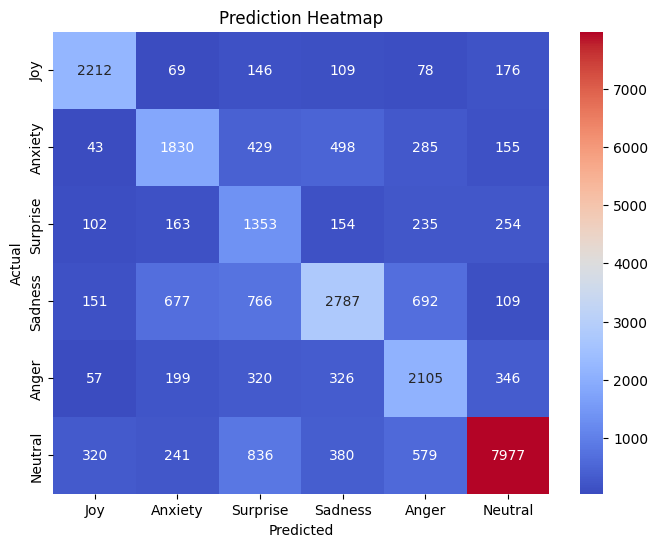

Label: Joy, Correct Predictions: 0.7667244367417677
Label: Anxiety, Correct Predictions: 0.5756527209814407
Label: Surprise, Correct Predictions: 0.3514285714285714
Label: Sadness, Correct Predictions: 0.655148095909732
Label: Anger, Correct Predictions: 0.5296930045294413
Label: Neutral, Correct Predictions: 0.8846623045358767


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 결과와 정답 레이블을 저장할 리스트 초기화
predictions = []
labels = []

# 각 라벨별 예측 맞은 개수 저장할 리스트 초기화
correct_counts = [0] * num_classes

# 테스트 데이터에 대한 예측 수행
for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    _, predicted = torch.max(y_pred, 1)
    predictions.extend(predicted.tolist())
    labels.extend(y_batch.tolist())

    # 각 라벨별 예측 맞은 개수 계산
    for i, label in enumerate(predicted):
        if label == y_batch[i]:
            correct_counts[label] += 1

# 예측 결과와 정답 레이블을 numpy 배열로 변환
predictions = np.array(predictions)
labels = np.array(labels)

# 클래스별로 예측 확률 값을 계산하여 2차원 배열로 변환
classes = ['Joy', 'Anxiety', 'Surprise', 'Sadness', 'Anger', 'Neutral']
num_classes = len(classes)

prediction_probs = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        prediction_probs[i, j] = np.sum((predictions == i) & (labels == j))

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(prediction_probs, cmap='coolwarm', xticklabels=classes, yticklabels=classes, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Prediction Heatmap')
plt.show()

# 각 라벨별 정답률
for i, label in enumerate(classes):
    print(f"Label: {label}, Correct Predictions: {correct_counts[i]/testlen[i]}")

In [41]:
!git checkout feature_sentiment-analysis
!git add .
!git commit -am "Test: 에포크별 정확도 테스트"
!git push origin feature_sentiment-analysis

Already on 'feature_sentiment-analysis'
Your branch is up to date with 'origin/feature_sentiment-analysis'.

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@41c2a72a59a9.(none)')
Everything up-to-date


In [43]:
!git log

commit 95d61c2b81e56fc3abe31f466bc83f6331fe3b7d (HEAD -> feature_sentiment-analysis, origin/feature_sentiment-analysis)
Merge: 7276bef 051f9d0
Author: kiwi_j500 <mingureion@gmail.com>
Date:   Wed May 24 22:25:15 2023 +0900

    Merge branch 'feature_sentiment-analysis' of https://github.com/Bongwoo2lee/floread into feature_sentiment-analysis

commit 7276beffd7d473cdfad74813975f512bfd7da679
Author: kiwi_j500 <mingureion@gmail.com>
Date:   Tue May 23 00:16:48 2023 +0900

    Fix: 클래스 수 조정

commit 051f9d0dafe6719c29617615fecb48a853b01adf
Author: 15zd <mingureion@gmail.com>
Date:   Mon May 22 14:11:06 2023 +0900

    파일 위치 & 오타 수정

commit dd1777dc426dde46e4521185106750be3f1f098a
Author: Inwoo Kang <mingureion@gmail.com>
Date:   Mon May 22 13:46:23 2023 +0900

    Save: trained model koelectra-v2

commit 9059d9850b3c3cf7df0b8a6e17b93eac46c00eb0
Author: kiwi_j500 <mingureion@gmail.com>
Date:   Wed May 17 11:04:51 2023 +0900

    Save: trained model kobert-v5

commit 2c64fa5b2cc1a533faedcc5a2